# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo</h1>

<p style="text-align: center;">Alex Dowling<sup>1,a</sup>, Jacob P. Krell<sup>2</sup>, David S. Mebane<sup>2,b</sup>, Kyla Jones<sup>1</sup></p>

<p style="text-align: center;"><sup>1</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>2</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

<sup>a</sup>adowling@nd.edu <br>
<sup>b</sup>david.mebane@mail.wvu.edu

---

## Introduction

TCLab has been modeled as a two state model, i.e., two-state ODE, predicting temperatures $T_{H,1}$ and $T_{S,1}$. However, a Gaussian process (GP) trained with measurements of $T_{S,1}$ may improve prediction accuracy. If the GP is trained on either $T_{S,1}$ or its numerically-calculated time derivative $\Delta T_{S,1}$, the GP may be plugged into the ODE to obtain $T_{H,1}$ predictions. The residual, i.e., the difference between ODE predictions and experimental measurements of $T_{S,1}$, may also be modeled with a GP to more accurately adjust predictions. These three methods are explored as follows.

### 1. Two-State Model

This is the original two-state ODE that will serve as a reference for comparison. The GP methods must outperform this benchmark.

$$\begin{align} 
\tag{1a} C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1 \\ 
\tag{1b} C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}$$

### 2. GP of $T_{S,1}$

Most simple would be to train the GP model $\mathbf{GP}_{T_{S,1}}$ on $\{T_{S,1} |\ t\}$; however, more physically true would be $\{T_{S,1} |\ t,\ Q_1,\ Q_2\}$.

#### 2.1. Univariate GP

A single-state ODE is formed.

$$\tag{2.1} C^H_p\frac{dT_{H,1}}{dt} = U_a(T_{amb} - T_{H,1}) + U_b(\mathbf{GP}_{T_{S,1}}(t) - T_{H,1}) + \alpha P_1u_1$$

#### 2.2. Multivariate GP

##### 2.2.1. Direct Implementation

A single-state ODE is formed.

$$\tag{2.2.1} C^H_p\frac{dT_{H,1}}{dt} = U_a(T_{amb} - T_{H,1}) + U_b(\mathbf{GP}_{T_{S,1}}(t, Q_1(t), Q_2(t)) - T_{H,1}) + \alpha P_1u_1$$

##### 2.2.2. Derivative via Chain Rule

A two-state ODE is formed. See Equation $(1a)$ for Equation $(2.2.2a)$.

$$\tag{2.2.2b} \frac{dT_{S,1}}{dt} = \frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial t} + \left(\frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial Q_1}\right) \left(\frac{dQ_1}{dt}\right) + \left(\frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial Q_2}\right) \left(\frac{dQ_2}{dt}\right) \text{ at } t$$

### 3. GP of $\Delta T_{S,1}$

Applying a smoothing function to $T_{S,1}$ measurements before taking the numerical gradient to arrive at $\Delta T_{S,1}$, $\mathbf{GP}_{\Delta T_{S,1}}$ may be trained on the simple $\{\Delta T_{S,1}\ |\ t\}$ or multivariate $\{\Delta T_{S,1}\ |\ t,\ Q_1,\ Q_2\}$.

#### 3.1. Univariate GP

A two-state ODE is formed. See Equation $(1a)$ for Equation $(3.1a)$.

$$\tag{3.1b} \frac{dT_{S,1}}{dt} = \mathbf{GP}_{\Delta T_{S,1}}(t)$$

#### 3.2. Multivariate GP

A two-state ODE is formed. See Equation $(1a)$ for Equation $(3.2a)$.

$$\tag{3.2b} \frac{dT_{S,1}}{dt} = \mathbf{GP}_{\Delta T_{S,1}}(t, Q_1(t), Q_2(t))$$

### 4. Residual

The residual of any of the above predictions may be modeled as a GP, $\mathbf{GP}_\text{res}$. However, constraining the overall method to one GP, only the residual of [Two-State Model](#1-two-state-model) will be trained. The training set is formed by $\{\left(T_{S,1}\right)_\text{obs} - \left(T_{S,1}\right)_\text{ODE}\ |\ t\}$ where $\text{obs}$ is an observation, i.e., experimental measurement, and $\text{ODE}$ is a prediction from Equation $(1)$. With the residual modeled, the prediction is enhanced with the following.

$$\tag{4} T_{S,1} = \left(T_{S,1}\right)_\text{ODE} + \mathbf{GP}_\text{res}$$

---

## Implementation

Import modules:

In [198]:
from FoKL import FoKLRoutines
# from FoKL.fokl_to_pyomo import fokl_to_pyomo
import os
dir = os.path.abspath('')  # directory of notebook
# -----------------------------------------------------------------------
# UNCOMMENT IF USING LOCAL FOKL PACKAGE:
import sys
sys.path.append(os.path.join(dir, '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Systems-level parameters:

In [199]:
filename = "tclab_sine_test.csv"
tmax = None  # maximum time for normalization bounds (increases ability to extrapolate GP models); 'None' uses data's max

Load and parse data:

In [200]:
data = pd.read_csv(os.path.join(dir, filename))

Q1 = data["Q1"].values
# Q2 = data["Q2"].values
TS1 = data["T1"].values
# TS2 = data["T2"].values
tvec = data["Time"].values

Smooth $T_{S,1}$ to obtain $\Delta T_{S,1}$:

In [201]:
# TS1_smooth = 
# dTS1 = gradient(TS1_smooth)

Train GPs:

In [202]:
# Initialize each GP with FoKL class:
GPs = {"list": ["TS1", "dTS1", "res"]}  # names of GPs
for GP in GPs["list"]:
    GPs.update({GP: FoKLRoutines.FoKL(kernel=1)})

# Convert system parameter 'tmax' to percent:
if tmax is None:
    tmax_p = 0
else:
    tmax_p = (tmax - tvec[-1]) / (tvec[-1] - tvec[0])

# Train GPs (except 'res'):
GPs["TS1"].fit([tvec, Q1], TS1, clean=True, pillow=[[0, tmax_p], [0, 0]])
# _ = GPs["dTS1"].fit([tvec, Q1, Q2], dTS1, clean=True, pillow=[[0, tmax_p], [0, 0], [0, 0]])

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, 3592.127247512837]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705099]
[4, 574.1060402705099]
[4, 540.9138514384176]
[4, -331.62357408654935]
[5, -331.62357408654935]
[5, -331.62357408654935]
[5, -384.5296810595524]
[6, -384.5296810595524]
[6, -384.5296810595524]
[6, -391.2268172424733]
[6, -394.6888620369673]
[7, -394.6888620369673]
[7, -394.6888620369673]
[7, -390.73500263956225]


(array([[ 50.37345751,  -2.22740257,  19.73245224, ..., -17.2679496 ,
          10.61200641,  -6.64141125],
        [ 50.33100602,  -1.93951887,  19.72267132, ..., -15.08491865,
          -0.77296685, -11.33703391],
        [ 50.31398511,  -1.96051646,  19.92976864, ..., -25.3735192 ,
           5.43056525,  -8.12723178],
        ...,
        [ 50.32692036,  -2.1394831 ,  19.82862218, ..., -17.51846644,
           7.44470989, -23.28776817],
        [ 50.38812235,  -1.94060587,  19.89926912, ..., -41.10888428,
          32.17856375, -30.21604605],
        [ 50.35143376,  -2.0790962 ,  19.82496153, ..., -17.85115012,
          28.03083138, -16.60463068]]),
 array([[0., 1.],
        [1., 0.],
        [1., 1.],
        [2., 0.],
        [2., 1.],
        [3., 0.],
        [1., 3.],
        [3., 1.],
        [4., 0.],
        [5., 0.],
        [5., 1.],
        [6., 0.]]),
 array([3592.12724751, 3587.24525143, 2325.61956988, 2307.57680916,
         574.10604027,  574.10604027,  540.91385144

Derivatives for chain rule:

In [214]:
dGPs = {"TS1": GPs["TS1"].bss_derivatives()}  # gradient

dTS1dt_f = interp1d(tvec, dGPs["TS1"][:, 0], kind='cubic', assume_sorted=True)
dTS1dQ1_f = interp1d(tvec, dGPs["TS1"][:, 1], kind='cubic', assume_sorted=True)
# dTS1dQ2_f = interp1d(tvec, dGPs["TS1"][:, 2], kind='cubic', assume_sorted=True)

Known heater power analytic expressions:

In [204]:
Q1_f = lambda t_: 50 * np.sin(30 * np.pi * t_ / tvec[-1]) + 50  # Q1 function
# Q2_f = lambda t_: 0

Q1dt_f = lambda t_: 1500 * np.cos(30 * np.pi * t_ / tvec[-1]) * np.pi / tvec[-1]
# Q2dt_f = lambda t_: 0

Chain rule:

In [205]:
dTS1_f = lambda t_: dTS1dt_f(t_) + dTS1dQ1_f(t_) * Q1dt_f(t_)  # + dTS1dQ2_f(t_) * Q2dt_f(t_)

ODE parameters:

In [206]:
alpha = 0.00016         # watts / (units P1 * percent U1)
P1 = 200                # P1 units
T_amb = TS1[0]          # ambient temperature

IC = [T_amb, T_amb]     # initial condition of states [TH1, TS1]
CpH =  7.006            # J/degC
CpS = 0.01              # J/degC
Ua =  0.051             # W/degC
Ub =  0.001             # W/degC

Define equations:

In [207]:
def eq_1a(TH1_, TS1_, Q1_):
    return (Ua * (T_amb - TH1_) + Ub * (TS1_ - TH1_) + alpha * P1 * Q1_) / CpH

Define ODEs:

In [252]:
def ode_chain(t, TS1_):
    return dTS1_f(t)

def ode_1(t, states):
    TH1_, TS1_ = states
    dTH1 = eq_1a(TH1_, TS1_, Q1_f(t))
    dTS1 = Ub * (TH1_ - TS1_) / CpS
    return [dTH1, dTS1]

def ode_2_2_2(t, states):
    TH1_, TS1_ = states
    
    Q1f_t = Q1_f(t)
    TS1_GP = GPs["TS1"].evaluate([t, Q1f_t], SingleInstance=True, clean=True)[0]
    dTH1 = eq_1a(TH1_, TS1_GP, Q1f_t)

    return [dTH1, dTS1_f(t)]

# def ode_2_2(t, states):
#     return

odes = {'chain': ode_chain, '1': ode_1, '2.2.2': ode_2_2_2}

Solve ODE showing accuracy of chain rule:

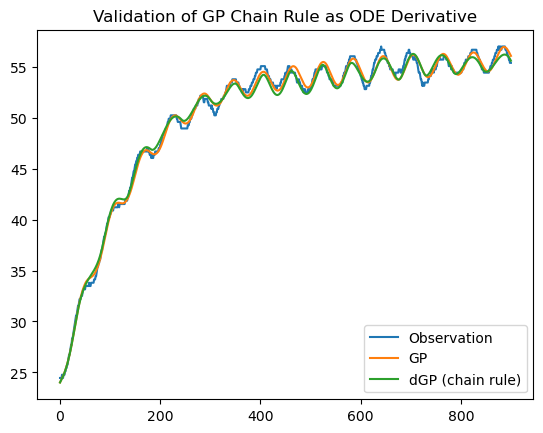

In [241]:
soln = solve_ivp(odes['chain'], [tvec[0], tvec[-1]], [GPs["TS1"].evaluate()[0]], t_eval=tvec)

pred_i = pd.DataFrame()
pred_i["TS1"] = soln.y[0]
pred = {'chain': pred_i}  # ODE predictions

# Plot:

plt.plot(TS1)
plt.plot(GPs["TS1"].evaluate())
plt.plot(pred["chain"]["TS1"])
plt.legend(["Observation", "GP", "dGP (chain rule)"])
plt.title('Validation of GP Chain Rule as ODE Derivative')
plt.show()

Solve original ODE for reference:

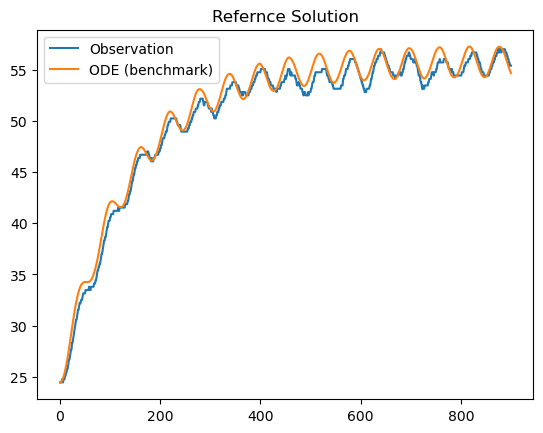

In [248]:
soln = solve_ivp(odes['1'], [tvec[0], tvec[-1]], IC, t_eval=tvec)

pred_i = pd.DataFrame()
pred_i["TH1"] = soln.y[0]
pred_i["TS1"] = soln.y[1]
pred.update({'1': pred_i})

# Plot:

plt.plot(TS1)
plt.plot(pred["1"]["TS1"])
plt.legend(["Observation", "ODE (benchmark)"])
plt.title('Reference Solution')
plt.show()

Solve 2.2.2. separately because ODE solver fails to converge:

In [266]:
tvec_dense = np.linspace(tvec[0], tvec[-1], int(1e5))
dt_dense = tvec_dense[1] - tvec_dense[0]

Q1_dense = Q1_f(tvec_dense)
TS1_GP_dense = GPs["TS1"].evaluate([tvec_dense, Q1_dense], clean=True)

TH1_dense = np.zeros_like(tvec_dense)
TH1_dense[0] = IC[0]
for i in range(tvec_dense.size - 1):
    dTH1_dense = eq_1a(TH1_dense[i], TS1_GP_dense[i], Q1_dense[i])
    TH1_dense[i + 1] = TH1_dense[i] + dTH1_dense * dt_dense

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


Text(0.5, 1.0, 'TH1 from 2.2.2.')

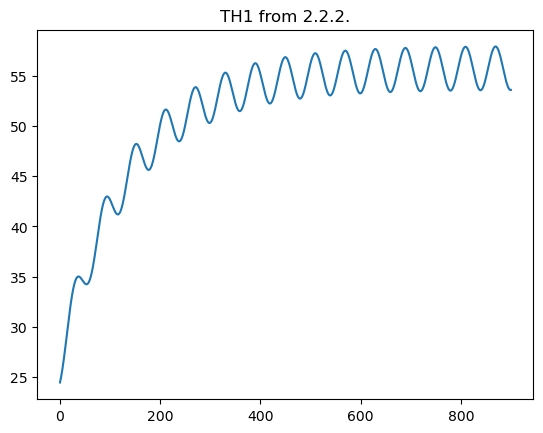

In [264]:
plt.plot(tvec_dense, TH1_dense)
plt.title("TH1 from 2.2.2.")

Solve ODEs:

In [265]:
cases = ['2.2.2']

for case in cases:
    print(f"Solving {case} ...")
    
    soln = solve_ivp(odes[case], [tvec[0], tvec[-1]], IC, t_eval=tvec)  # solve ODE

    pred_i = pd.DataFrame()
    pred_i["TH1"] = soln.y[0]
    pred_i["TS1"] = soln.y[1]

    pred.update({case: pred_i})

Solving 2.2.2 ...


KeyboardInterrupt: 

Plot solutions:

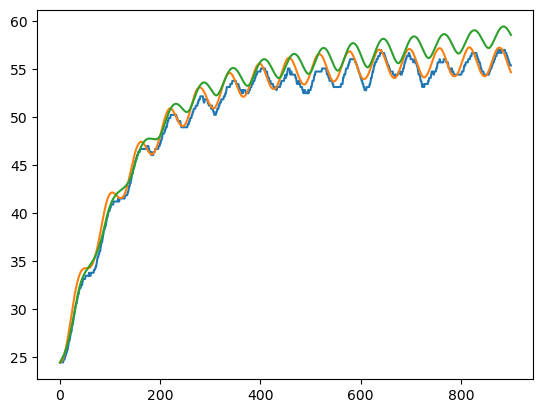

In [250]:
fig, ax = plt.subplots()
ax.plot(tvec, TS1)
ax.plot(tvec, pred['1']['TS1'])
ax.plot(tvec, pred['2.2.2_test']['TS1'])

### Comparison of chain rule with other method, since chain rule not great

Instead of chain rule derivative, using numeric derivative on smoothed data (but using GP as the smoothed data instead of a rolling average):

In [267]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx


dTS1_GP_dense = gradient_h4(TS1_GP_dense, dt_dense)

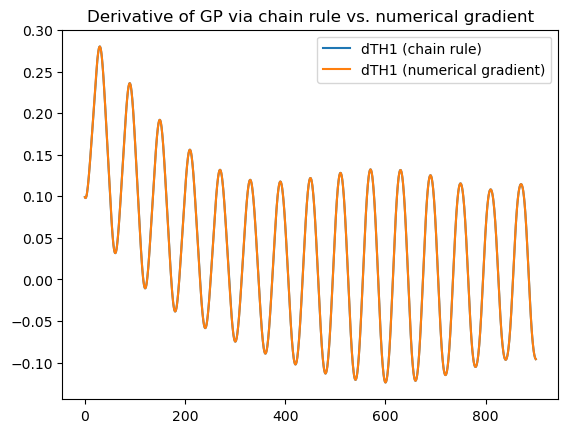

In [270]:
plt.plot(tvec_dense, dTS1_GP_dense)
plt.plot(tvec, dTS1_f(tvec))
plt.title("Derivative of GP via chain rule vs. numerical gradient")
plt.legend(["dTH1 (chain rule)", "dTH1 (numerical gradient)"])

## Conclusion

Plot of chain rule vs. numeric gradient proves equivalence, so any smoothing function would *need to outperform the smoothing inherent in the GP* $\mathbf{GP}_{T_{S,1}}$.

## Attempting to outperform GP smoothing

In [325]:
window = 9  # odd number, mean at center +/- floor(window/2))

Text(0.5, 1.0, 'Numeric derivative of smoothed data')

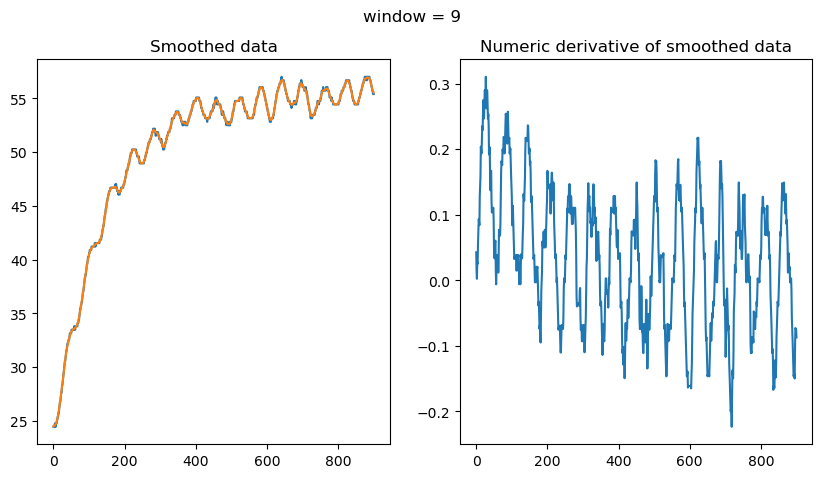

In [326]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

# -----------------------------------------
# Smoothing:

TS1_smooth = smooth(TS1, window)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}")
axs[0].plot(TS1)
axs[0].plot(TS1_smooth)
axs[0].set_title("Smoothed data")

# -----------------------------------------
# Derivative:

dTS1_smooth = gradient_h4(TS1_smooth, tvec[1] - tvec[0])

axs[1].plot(dTS1_smooth)
axs[1].set_title("Numeric derivative of smoothed data")

Training a GP on the numeric smoothed derivative:

In [327]:
GP_dTS1_smooth = FoKLRoutines.FoKL(kernel=1)
GP_dTS1_smooth.fit([tvec, Q1], dTS1_smooth, clean=True)

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -3427.1601239168454]
[2, -3427.1601239168454]
[2, -3490.1002283566936]
[3, -3490.1002283566936]
[3, -3485.9222837454677]
[4, -3485.9222837454677]


(array([[ 0.03572002,  0.07272072, -0.12206312,  0.02491059,  0.25518022],
        [ 0.02762224,  0.0668703 , -0.14246432,  0.06912859,  0.36547045],
        [ 0.03217591,  0.08064336, -0.13306331,  0.03830318,  0.2739407 ],
        ...,
        [ 0.03282847,  0.0777721 , -0.11236594, -0.00748585,  0.30072227],
        [ 0.03527049,  0.07112256, -0.1258253 ,  0.00627669,  0.29563162],
        [ 0.02885031,  0.07754654, -0.12054136,  0.05711136,  0.2843081 ]]),
 array([[0., 1.],
        [1., 0.],
        [0., 2.],
        [2., 0.]]),
 array([-3427.16012392, -3427.16012392, -3490.10022836, -3490.10022836,
        -3485.92228375, -3485.92228375]))

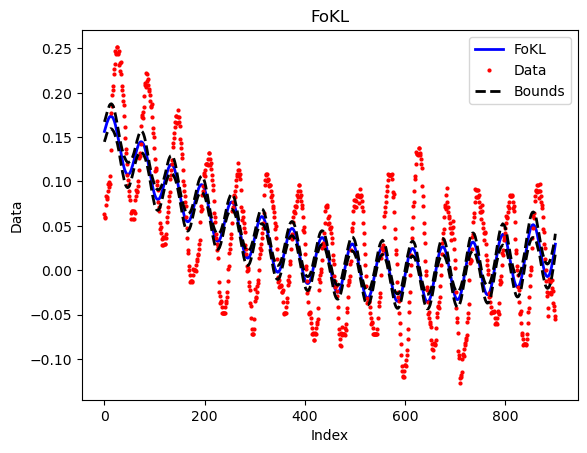

(array([ 1.56462088e-01,  1.58418090e-01,  1.60371523e-01,  1.62332859e-01,
         1.64296854e-01,  1.66263508e-01,  1.67735560e-01,  1.69209911e-01,
         1.70686559e-01,  1.71667705e-01,  1.72655887e-01,  1.73137647e-01,
         1.73626083e-01,  1.73617574e-01,  1.73610281e-01,  1.73105321e-01,
         1.72601217e-01,  1.71598725e-01,  1.70596727e-01,  1.69095621e-01,
         1.67594649e-01,  1.65593846e-01,  1.63592817e-01,  1.61091236e-01,
         1.58589068e-01,  1.55585627e-01,  1.53082104e-01,  1.50076948e-01,
         1.47070844e-01,  1.44063791e-01,  1.41060797e-01,  1.37550084e-01,
         1.34535000e-01,  1.31523977e-01,  1.28512005e-01,  1.25499086e-01,
         1.22987888e-01,  1.20481110e-01,  1.17963731e-01,  1.15953981e-01,
         1.13944006e-01,  1.12437374e-01,  1.10930877e-01,  1.09928445e-01,
         1.08926508e-01,  1.08429358e-01,  1.07933064e-01,  1.07942278e-01,
         1.07952707e-01,  1.08474292e-01,  1.08987602e-01,  1.10012789e-01,
         1.1

In [318]:
GP_dTS1_smooth.coverage3(plot=True)

Attempting to interpolate so that more training data points forces more accurate GP:

In [328]:
interp_dTS1_smooth = interp1d(tvec, dTS1_smooth)
dTS1_smooth_dense = interp_dTS1_smooth(tvec_dense)

In [329]:
GP_dTS1_smooth_dense = FoKLRoutines.FoKL(kernel=1)
GP_dTS1_smooth_dense.fit([tvec_dense, Q1_dense], dTS1_smooth_dense, clean=True)

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -383364.9165610454]
[2, -383356.21612341853]
[2, -392133.7146453556]
[3, -392158.6987052433]
[3, -393195.9306816979]
[4, -393246.8946164723]
[4, -394025.32782123284]
[4, -394104.0946248366]
[5, -394143.8241061932]
[5, -394334.19658640673]
[5, -394513.3323768695]
[6, -394541.48874083336]
[6, -394531.1945846657]
[6, -395780.11781010125]
[6, -396037.56005978584]
[7, -396044.3718428672]
[7, -396404.1719029936]
[7, -396619.0667266068]
[7, -396743.1752681516]
[8, -396806.2892789674]
[8, -397213.54253967875]
[8, -397231.8236310358]
[8, -398659.28991667426]
[8, -398931.8639011659]
[9, -398979.7365081339]
[9, -398997.74945821526]
[9, -398991.9025709138]
[9, -399071.5760320054]
[9, -399219.03333829844]
[10, -399219.3884245181]
[10, -399289.19575375936]
[10, -399408.88081672654]
[10, -399409.93146895035]
[10, -399939.70704673015]
[10, -399991.20818012964]
[11, -399980.5751366731]
[11, -400263.3685424736]
[11, -400243.02809416637]
[11, -400348.43605429976]
[11, -400634.2568196398]
[11, -400737

(array([[ 4.76346594e-02,  8.99278730e-02, -1.28183970e-01, ...,
          6.17968786e+01, -2.70431528e+02, -8.81281437e+01],
        [ 4.82915487e-02,  9.23672235e-02, -1.29217753e-01, ...,
          6.30156591e+01, -3.20852616e+02, -5.00296239e+01],
        [ 4.91831426e-02,  9.33798255e-02, -1.24470543e-01, ...,
          6.26358180e+01, -3.10809130e+02, -1.04487967e+02],
        ...,
        [ 4.92275125e-02,  9.09347817e-02, -1.25168055e-01, ...,
          6.10631298e+01, -4.48206942e+02, -1.92267854e+02],
        [ 4.80278274e-02,  9.07759282e-02, -1.27896623e-01, ...,
          6.21559624e+01, -3.40069708e+02, -9.18349363e+01],
        [ 4.86587223e-02,  9.07868181e-02, -1.24626351e-01, ...,
          6.25801477e+01, -2.78370038e+02, -1.14900896e+02]]),
 array([[ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 0.,  2.],
        [ 2.,  0.],
        [ 1.,  2.],
        [ 2.,  1.],
        [ 0.,  3.],
        [ 3.,  0.],
        [ 2.,  2.],
        [ 1.,  3.],
        [

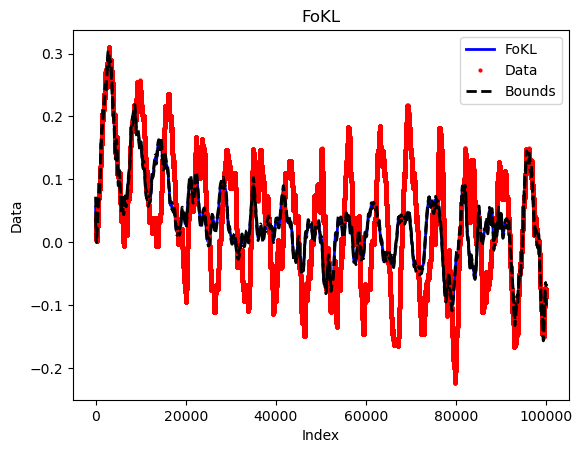

MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64

In [330]:
GP_dTS1_smooth_dense.coverage3(plot=True)